# Simple Refridgeration Cycle

Alex Dowling, University of Notre Dame

Thank you ChatGPT!

## Import and Configure Thermodynamics

In [39]:
# Import required IDAES-PSE modules
from idaes.core import FlowsheetBlock
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
    AmountBasis,
)
from idaes.models.unit_models import (Heater, Turbine, Compressor, 
                                      Mixer, Separator, PressureChanger,
                                      Valve)
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors
from pyomo.environ import ConcreteModel, value, Objective, SolverFactory, maximize, minimize
from idaes.core.util.initialization import propagate_state
from pyomo.network import Arc
from pyomo.environ import units as pyunits
import numpy as np
import matplotlib.pyplot as plt

# Create the ConcreteModel and Flowsheet
model = ConcreteModel()
model.fs = FlowsheetBlock(dynamic=False)

# Add property package for a common refrigerant (e.g., R134a) using General Helmholtz model
model.fs.properties = HelmholtzParameterBlock(pure_component="R134a", state_vars=StateVars.TPX, amount_basis=AmountBasis.MASS)

# Using mass basis to make initialization easier
# model.fs.properties = HelmholtzParameterBlock(pure_component="R134a", state_vars=StateVars.PH, amount_basis=AmountBasis.MASS)

## Generate Diagrams from Thermodynamics Package


![](https://www.researchgate.net/profile/Maruti-Sinha-2/publication/330833111/figure/fig3/AS:721930424442886@1549133034275/P-H-diagram-showing-the-refrigeration-cycle-for-an-air-conditioner-with-R-134a.jpg)

Ideas:


In [40]:
import CoolProp.CoolProp as CP
import numpy as np

# Define the fluid
fluid = 'R134a'

# Define the pressure (in Pa) and enthalpy (in J/kg)
pressure = 5e5  # Example pressure in Pa
enthalpy = 200e3  # Example enthalpy in J/kg

# Calculate the temperature (in K)
temperature = CP.PropsSI('T', 'P', pressure, 'H', enthalpy, fluid)

print(f'Temperature: {temperature} K')

Temperature: 273.114689255431 K


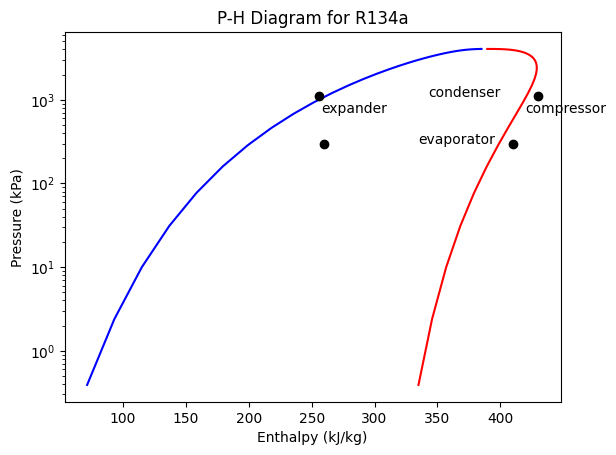

In [41]:
model.fs.properties.hp_diagram()

# guess values for initial points
h_init = [410, 430, 256, 260] # kJ/kg
p_init = [300, 1100, 1100, 300] # kPa

T_init = np.zeros(len(h_init))
for i in range(len(h_init)):
    # Inputs are in J/kg and Pa, hence 1000 is needed for unit conversion
    T_init[i] = CP.PropsSI('T', 'H', h_init[i]*1000, 'P', p_init[i]*1000, fluid)


step_names = ['compressor', 'condenser', 'expander', 'evaporator']


for i in range(len(step_names)):
    h_avg = (h_init[i] + h_init[(i+1)%4])/2
    p_avg = (p_init[i] + p_init[(i+1)%4])/2
    plt.text(h_avg, p_avg, step_names[i])

plt.plot(h_init, p_init, 'ko')

plt.show()

In [42]:
'''
from pyomo.environ import units
import pandas as pd

# Set operating conditions
high_pressure = ((85 - 32) * 5/9 + 273.15)*units.K  # Convert 130 F to Kelvin
low_pressure = ((65 - 32) * 5/9 + 273.15)*units.K   # Convert 50 F to Kelvin


points = ['A', 'B', 'C', 'D']
T = [high_pressure, low_pressure, low_pressure, high_pressure]
x = [0, 0, 1, 1]
h = np.zeros(len(points))
s = np.zeros(len(points))

for i, p in enumerate(points):
    h[i] = model.fs.properties.htpx(T=T[i], x = x[i])
    s[i] = model.fs.properties.stpx(T=T[i], x = x[i])

data = {
    'Point': points,
    'Temperature (K)': [value(temp) for temp in T],
    'Vapor Fraction': x,
    'Enthalpy (J/mol)': h,
    'Entropy (J/mol.K)': s
}

df = pd.DataFrame(data)
df.head()
'''
print("")

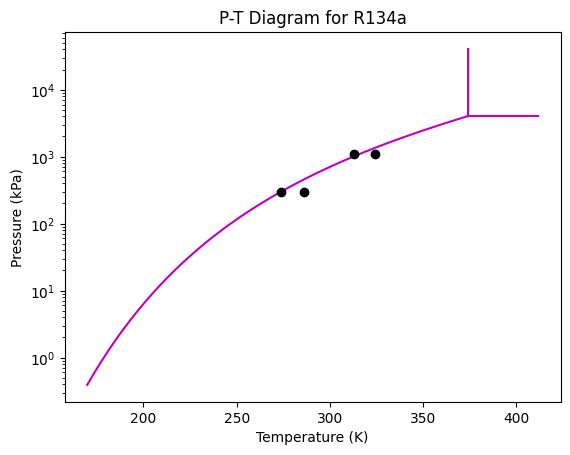

In [43]:
model.fs.properties.pt_diagram()

if False:
    for i in range(len(step_names)):
        p_avg = (p_init[i] + p_init[(i+1)%4])/2
        T_avg = (T_init[i] + T_init[(i+1)%4])/2
        plt.text(T_avg, p_avg, step_names[i])

plt.plot(T_init, p_init, 'ko')
plt.show()

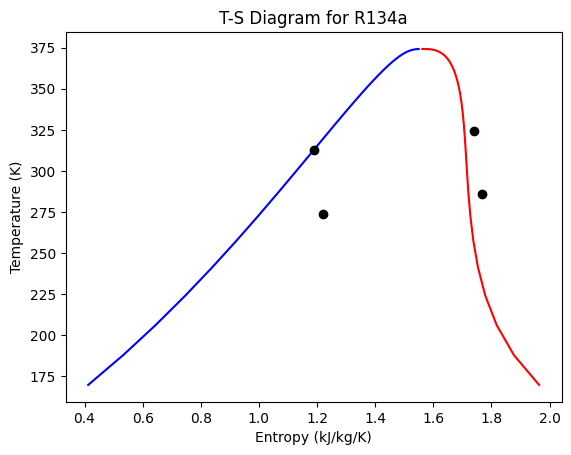

In [44]:
model.fs.properties.st_diagram()

S_init = np.zeros(len(h_init))
for i in range(len(h_init)):
    # Inputs are in J/kg and Pa, hence 1000 is needed for unit conversion
    # Output has units J/kg.K, hence 1000 is needed for unit conversion
    S_init[i] = CP.PropsSI('S', 'H', h_init[i]*1000, 'P', p_init[i]*1000, fluid)/1000

plt.plot(S_init, T_init, 'ko')

plt.show()

## Simple Flowsheet

Challenge: Initialization is failing to convergence, possibly too few degrees of freedom for some units.

Ideas:
- Switch to alternate state representation
- Use helper functions for enthalpy and entropy to compute initial points
- Determine reasonable initial points from the phase diagrams/thermodynamic charts
- Attempt to simulate each unit operation is isolation first

Eventual enhancements:
- Plot streams from simple cycle on the three thermodyanmic charts
- Use more sophisticated thermodynamic assumption for compressor

In [45]:
import logging
# Set up logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

# Add unit models to the flowsheet
model.fs.evaporator = Heater(property_package=model.fs.properties)
model.fs.compressor = Compressor(property_package=model.fs.properties)
model.fs.condenser = Heater(property_package=model.fs.properties)


model.fs.expansion_valve = PressureChanger(property_package=model.fs.properties, 
                                           thermodynamic_assumption="adiabatic",
                                           compressor=False)

# Let's use a valve instead of a pressure changer
# model.fs.expansion_valve = Valve(property_package=model.fs.properties)
                                           
# Connect components with arcs
model.fs.evaporator_to_compressor = Arc(source=model.fs.evaporator.outlet, 
                                        destination=model.fs.compressor.inlet)
model.fs.compressor_to_condenser = Arc(source=model.fs.compressor.outlet, 
                                       destination=model.fs.condenser.inlet)
model.fs.condenser_to_expansion_valve = Arc(source=model.fs.condenser.outlet, 
                                            destination=model.fs.expansion_valve.inlet)
model.fs.expansion_valve_to_evaporator = Arc(source=model.fs.expansion_valve.outlet, 
                                             destination=model.fs.evaporator.inlet)

# Expand arcs to build the connectivity
#from idaes.core.util import model_serializer as ms
# expand_arcs(model.fs.evaporator_to_compressor)

from pyomo.environ import TransformationFactory
TransformationFactory('network.expand_arcs').apply_to(model)

# Deactivate the flowrate constraint on one of the arcs
# model.fs.evaporator_to_compressor_expanded.flow_mol_equality.deactivate()
model.fs.evaporator_to_compressor_expanded.flow_mass_equality.deactivate()

# Evaporator (low-pressure side)
# model.fs.evaporator.inlet.flow_mol[0].fix(1)   # Example value
# model.fs.evaporator.inlet.enth_mol[0].fix(h_init[-1])

'''
model.fs.evaporator.inlet.pressure[0].fix(p_init[-1]*scale_input_p)
#model.fs.evaporator.outlet.temperature[0].fix(indoor_temp - delta_T_evaporator)
#model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)  # Ensure vapor phase
#model.fs.evaporator.outlet.pressure[0].fix(p_init[0]*scale_input_p)
model.fs.evaporator.outlet.enth_mass[0].fix(h_init[0]*scale_input_h)

# Compressor (compressing the vapor)
model.fs.compressor.outlet.pressure[0].fix(p_init[1]*scale_input_p)
# model.fs.compressor.outlet.enth_mass[0].fix(h_init[1]*scale_input_h)

# Condenser (high-pressure side)
# model.fs.condenser.outlet.pressure[0].fix(p_init[2]*scale_input_p)
model.fs.condenser.outlet.enth_mass[0].fix(h_init[2]*scale_input_h)

# Expansion Valve
# No pressure fix here, the outlet phase constraints handle the operation
# model.fs.expansion_valve.inlet.pressure[0].fix(p_init[3]*scale_input_p)
model.fs.expansion_valve.outlet.enth_mass[0].fix(h_init[3]*scale_input_h)

# Set up scaling and check degrees of freedom
calculate_scaling_factors(model)
# assert degrees_of_freedom(model) == 0'
'''



"\nmodel.fs.evaporator.inlet.pressure[0].fix(p_init[-1]*scale_input_p)\n#model.fs.evaporator.outlet.temperature[0].fix(indoor_temp - delta_T_evaporator)\n#model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)  # Ensure vapor phase\n#model.fs.evaporator.outlet.pressure[0].fix(p_init[0]*scale_input_p)\nmodel.fs.evaporator.outlet.enth_mass[0].fix(h_init[0]*scale_input_h)\n\n# Compressor (compressing the vapor)\nmodel.fs.compressor.outlet.pressure[0].fix(p_init[1]*scale_input_p)\n# model.fs.compressor.outlet.enth_mass[0].fix(h_init[1]*scale_input_h)\n\n# Condenser (high-pressure side)\n# model.fs.condenser.outlet.pressure[0].fix(p_init[2]*scale_input_p)\nmodel.fs.condenser.outlet.enth_mass[0].fix(h_init[2]*scale_input_h)\n\n# Expansion Valve\n# No pressure fix here, the outlet phase constraints handle the operation\n# model.fs.expansion_valve.inlet.pressure[0].fix(p_init[3]*scale_input_p)\nmodel.fs.expansion_valve.outlet.enth_mass[0].fix(h_init[3]*scale_input_h)\n\n# Set up scaling and check d

In [46]:
# p_init has units of kPa, hence the scale factor is 1e3 to get Pa
p_scale = 1e3

model.fs.evaporator.inlet.flow_mass[0].fix(1)   # Example value
model.fs.evaporator.inlet.temperature[0].fix(T_init[-1])
model.fs.evaporator.inlet.pressure[0].fix(p_init[-1]*p_scale)

model.fs.evaporator.outlet.temperature[0].fix(T_init[0])

logger.info("Initializing evaporator...")
model.fs.evaporator.initialize(outlvl=logging.WARNING)
model.fs.evaporator.report()


Unit : fs.evaporator                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value      : Units : Fixed : Bounds
    Heat Duty : 2.0910e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     273.82     286.14
    P                          pascal 3.0000e+05 3.0000e+05
    Vapor Fraction      dimensionless     0.0000     1.0000
    Mass Enthalpy    joule / kilogram 2.0090e+05 4.1000e+05


In [47]:
propagate_state(model.fs.evaporator_to_compressor)

In [48]:
model.fs.compressor.inlet.temperature[0].fix()
model.fs.compressor.inlet.pressure[0].fix()

model.fs.compressor.outlet.pressure[0].fix(p_init[1]*p_scale) # Set to target
# model.fs.compressor.outlet.vapor_frac[0].fix(1.0)  # Ensure vapor phase

model.fs.compressor.efficiency_isentropic.fix(0.85)  # Example value

logger.info("Initializing compressor...")
model.fs.compressor.initialize(outlvl=logging.WARNING)
model.fs.compressor.report()



Unit : fs.compressor                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                   : Value      : Units         : Fixed : Bounds
    Isentropic Efficiency :    0.85000 : dimensionless :  True : (None, None)
          Mechanical Work :     33942. :          watt : False : (None, None)
          Pressure Change : 8.0000e+05 :        pascal : False : (None, None)
           Pressure Ratio :     3.6667 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     286.14     316.12
    P                          pascal 3.0000e+05 1.1000e+06
   

In [49]:
propagate_state(model.fs.compressor_to_condenser)

In [50]:
model.fs.condenser.inlet.temperature[0].fix()
model.fs.condenser.inlet.pressure[0].fix()

model.fs.condenser.outlet.vapor_frac[0].fix(0.0)  # Ensure liquid phase

logger.info("Initializing condenser...")
model.fs.condenser.initialize(outlvl=logging.WARNING)
model.fs.condenser.report()


Unit : fs.condenser                                                        Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value       : Units : Fixed : Bounds
    Heat Duty : -1.8307e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     316.12     316.12
    P                          pascal 1.1000e+06 1.1000e+06
    Vapor Fraction      dimensionless     1.1455     0.0000
    Mass Enthalpy    joule / kilogram 4.4394e+05 2.6087e+05


In [51]:
propagate_state(model.fs.condenser_to_expansion_valve)

In [52]:
model.fs.expansion_valve.inlet.temperature[0].fix()
model.fs.expansion_valve.inlet.pressure[0].fix()

# model.fs.expansion_valve.outlet.pressure[0].fix(p_init[3]*p_scale) # Set to target pressure
# model.fs.expansion_valve.work_isentropic[0].fix(0.0)  # Isentropic expansion
# model.fs.expansion_valve.work_mechanical[0].fix(0.0)  # No mechanical work

logger.info("Initializing expansion valve...")
model.fs.expansion_valve.initialize(outlvl=logging.WARNING)
model.fs.expansion_valve.report()



Unit : fs.expansion_valve                                                  Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Units         : Fixed : Bounds
    Mechanical Work : 0.0000 :          watt : False : (None, None)
    Pressure Change : 67604. :        pascal : False : (None, None)
     Pressure Ratio : 1.0615 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     316.12     318.40
    P                          pascal 1.1000e+06 1.1676e+06
    Vapor Fraction      dimensionless     0.0000  -0.022021
    Mass Enthalpy    joule / kilogram 2.6087e+05 2.6087e+05


In [53]:
# Unfix the conditions set previously

unit_operations = [model.fs.evaporator, model.fs.compressor, model.fs.condenser, model.fs.expansion_valve]

for unit in unit_operations:
    unit.inlet.flow_mass[0].unfix()
    unit.inlet.temperature[0].unfix()
    unit.inlet.pressure[0].unfix()
    unit.outlet.flow_mass[0].unfix()
    unit.outlet.temperature[0].unfix()
    unit.outlet.pressure[0].unfix()

    unit.inlet.vapor_frac[0].setlb(0)
    unit.inlet.vapor_frac[0].setub(1)


In [54]:
# Fix specifications for a typical refrigeration cycle

low_side_pessure_min = 2E5 # Pa
low_side_pressure_max = 5E5 # Pa

high_side_pressure_min = 1E6 # Pa
high_side_pressure_max = 3E6 # Pa

# Evaporator (low-pressure side)
model.fs.evaporator.inlet.flow_mass[0].fix(1)       # Specify the mass flow rate

model.fs.evaporator.inlet.pressure[0].setlb(low_side_pessure_min)
model.fs.evaporator.inlet.pressure[0].setub(low_side_pressure_max)

model.fs.evaporator.outlet.vapor_frac[0].setlb(0.999)  # Ensure vapor phase
model.fs.evaporator.outlet.temperature[0].setlb(273.15 - 20)  # -20 degrees C
model.fs.evaporator.outlet.temperature[0].setub(273.15 + 20)  # +20 degrees C

'''
@model.fs.evaporator.Constraint()
def vapor_frac_evaporator_out(b):
    return b.control_volume.properties_out[0].vapor_frac >= 0.999
'''

'''
@model.fs.evaporator.Constraint()
def lower_temperature_evaporator_out(b):
    return b.control_volume.properties_out[0].temperature >= 273.15 - 20 # -20 degrees C
'''

'''
@model.fs.evaporator.Constraint()
def upper_temperature_evaporator_out(b):
    return b.control_volume.properties_out[0].temperature <= 273.15 + 20 # +20 degrees C
'''

# model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)

# Compressor (compressing the vapor)
# model.fs.compressor.outlet.pressure[0].fix(p_init[1] * scale_input_p)

model.fs.compressor.inlet.pressure[0].setlb(low_side_pessure_min)
model.fs.compressor.inlet.pressure[0].setub(low_side_pressure_max)

'''
@model.fs.compressor.Constraint()
def vapor_frac_compressor_out(b):
    return b.control_volume.properties_out[0].vapor_frac >= 0.999
'''

model.fs.compressor.outlet.vapor_frac[0].setlb(0.999)  # Ensure vapor phase

model.fs.compressor.outlet.pressure[0].setlb(high_side_pressure_min)
model.fs.compressor.outlet.pressure[0].setub(high_side_pressure_max)

# model.fs.compressor.inlet.vapor_frac[0].fix(1)# Assume the compressor is compressing vapor
# model.fs.compressor.outlet.vapor[0].fix(1) # Assume the compressor is compressing vapor

# Condenser (high-pressure side)
# model.fs.condenser.outlet.enth_mass[0].fix(h_init[2] * scale_input_h)

model.fs.compressor.work_mechanical.setlb(0)  # Assume no work output from the compressor, only input work

'''
@model.fs.condenser.Constraint()
def temperature_condenser_out(b):
    return b.control_volume.properties_out[0].temperature >= 273.15 + 30 # above 30 C

@model.fs.condenser.Constraint()
def temperature_condenser_in(b):
    return b.control_volume.properties_in[0].temperature >= 273.15 + 30 # above 30 C

@model.fs.condenser.Constraint()
def vapor_frac_condenser_out(b):
    return b.control_volume.properties_out[0].vapor_frac <= 0.001
'''

model.fs.condenser.outlet.vapor_frac[0].setub(0.001)  # Ensure liquid phase
model.fs.condenser.outlet.temperature[0].setlb(273.15 + 30)  # +30 degrees C
model.fs.condenser.inlet.temperature[0].setlb(273.15 + 30)  # +30 degrees C


# Expansion Valve
# model.fs.expansion_valve.outlet.enth_mass[0].fix(h_init[3] * scale_input_h)

# model.fs.expansion_valve.heat_duty.fix(0)  # Assume no heat loss in the expansion valve

model.fs.expansion_valve.inlet.pressure[0].setlb(high_side_pressure_min)
model.fs.expansion_valve.inlet.pressure[0].setub(high_side_pressure_max)


# model.fs.expansion_valve.work_isentropic.fix(0) # Isentropic expansion
# model.fs.expansion_valve.work_isentropic.setlb(0)  # No mechanical work
# model.fs.expansion_valve.work_isentropic.setub(1e-3)  # No mechanical work
# model.fs.expansion_valve.work_mechanical.fix(0)  # Not needed as it is already fixed

# model.fs.expansion_valve.efficiency_isentropic.fix(0.95)  # Expansion valve efficiency

model.fs.expansion_valve.outlet.pressure[0].setlb(low_side_pessure_min)
model.fs.expansion_valve.outlet.pressure[0].setub(low_side_pressure_max)


model.fs.expansion_valve.outlet.vapor_frac[0].setlb(0.001) # Ensure two phase outlet
model.fs.expansion_valve.outlet.vapor_frac[0].setub(0.999) # Ensure two phase outlet

# Set up scaling and check degrees of freedom
calculate_scaling_factors(model)
assert degrees_of_freedom(model) >= 0

2025-03-09 16:48:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.evaporator.control_volume.heat


2025-03-09 16:48:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.compressor.control_volume.work


2025-03-09 16:48:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser.control_volume.heat


2025-03-09 16:48:11 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.expansion_valve.control_volume.work


In [55]:
# for i in dir(model.fs.compressor):
#    print(i)

In [56]:
#for i in dir(model.fs.compressor.control_volume):
#    print(i)

In [57]:
# model.fs.compressor.control_volume.pprint()

In [58]:
# model.fs.compressor.control_volume.properties_out[0].temperature.pprint()

In [59]:
# model.fs.compressor.control_volume.properties_out[0].vapor_frac

In [60]:
model.fs.evaporator.heat_duty.pprint()

heat_duty : Size=1, Index=fs._time, ReferenceTo=fs.evaporator.control_volume.heat
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : 209096.50725821912 :  None : False :  True :  Reals


In [61]:
# Add objective function to maximize the coefficient of performance (COP)



# model.fs.cooling = Objective(expr=model.fs.condenser.heat_duty[0], sense=minimize)

# model.fs.cooling = Objective(expr=model.fs.evaporator.heat_duty[0], sense=minimize)

# model.fs.dummy = Objective(expr=0, sense=minimize)

# Solver setup

solver = get_solver()

solver.options = {'max_iter': 500}

# Solve the model
results = solver.solve(model, tee=True)

if False:
    # We are using external functions, which means we cannot try other
    # solvers on NEOS.
    import os
    from pyomo.environ import SolverManagerFactory
    os.environ["NEOS_EMAIL"] = "adowling@nd.edu"
    solver_manager = SolverManagerFactory('neos')
    
    opt = SolverFactory('minos')

    results = solver_manager.solve(model, tee=True, opt=opt)


# Print results
if results.solver.termination_condition == 'optimal':
    print("Refrigeration cycle solved successfully.")
    # print("Coefficient of Performance (COP):", value(model.fs.COP))
    # print("Evaporator outlet temperature:", value(model.fs.evaporator.outlet.temperature[0]))
    # print("Compressor outlet phase:", model.fs.compressor.outlet.phase[0].value)
    # print("Condenser outlet temperature:", value(model.fs.condenser.outlet.temperature[0]))
    # print("Condenser outlet phase:", model.fs.condenser.outlet.phase[0].value)
else:
    print("Refrigeration cycle did not converge.")

model.fs.report()



Ipopt 3.13.2: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation

In [62]:
# Set objective
model.fs.COP = Objective(expr=(model.fs.evaporator.heat_duty[0]) /
                         (model.fs.compressor.work_mechanical[0]), sense=maximize)


# Try solve again
results = solver.solve(model, tee=True)

model.fs.report()

Ipopt 3.13.2: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation

In [63]:
for unit in unit_operations:
    unit.report()


Unit : fs.evaporator                                                       Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value      : Units : Fixed : Bounds
    Heat Duty : 1.4789e+05 :  watt : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                         Units           Inlet     Outlet  
    Molar Flow          mole / second     9.8008     9.8008
    Mass Flow       kilogram / second     1.0000     1.0000
    T                          kelvin     284.70     284.70
    P                          pascal 4.3644e+05 4.3644e+05
    Vapor Fraction      dimensionless    0.21944    0.99998
    Mass Enthalpy    joule / kilogram 2.5728e+05 4.0517e+05

Unit : fs.compressor                                                       Time: 0.0
-----------------------------------------------------------------------

In [64]:
# This is way to high... probably need to adjust some temperature bounds
print("Optimized COP:", round(value(model.fs.COP),3))

h_sol = np.zeros(len(h_init))
p_sol = np.zeros(len(p_init))
T_sol = np.zeros(len(h_init))
S_sol = np.zeros(len(h_init))

for i, unit in enumerate(unit_operations):
    h_sol[i] = unit.control_volume.properties_out[0].enth_mass()
    p_sol[i] = unit.outlet.pressure[0].value
    T_sol[i] = unit.outlet.temperature[0].value
    S_sol[i] = unit.control_volume.properties_out[0].entr_mass()

Optimized COP: 6.98


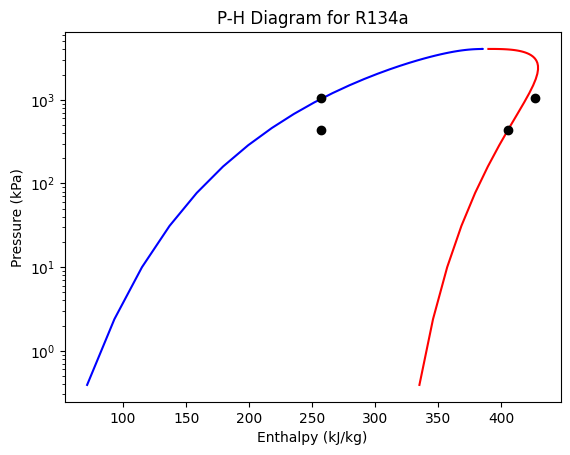

In [65]:
model.fs.properties.hp_diagram()
plt.plot(h_sol/1000, p_sol/1000, 'ko')
plt.show()

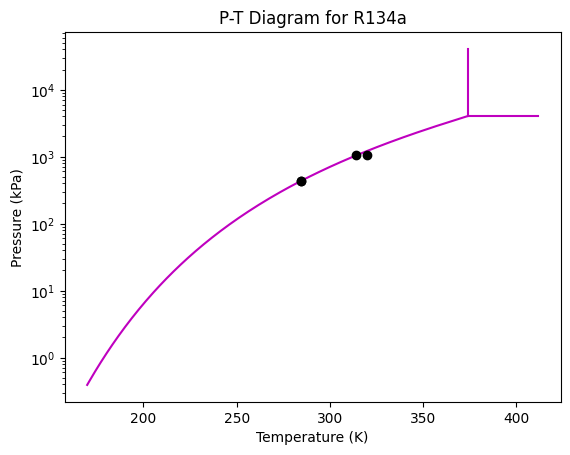

In [66]:
model.fs.properties.pt_diagram()
plt.plot(T_sol, p_sol/1000, 'ko')
plt.show()

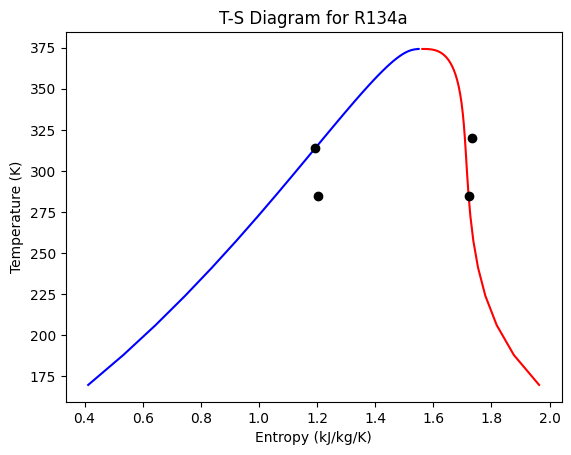

In [67]:
model.fs.properties.st_diagram()
plt.plot(S_sol/1000, T_sol, 'ko')
plt.show()

In [68]:
from idaes.core.util import DiagnosticsToolbox

# Create a diagnostics toolbox instance
diag = DiagnosticsToolbox(model, constraint_residual_tolerance=1e-4)

diag.display_constraints_with_large_residuals()

The following constraint(s) have large residuals (>1.0E-04):




In [69]:
# model.fs.evaporator.display()

In [70]:
diag.report_structural_issues()

Model Statistics

        Activated Blocks: 26 (Deactivated: 0)
        Free Variables in Activated Constraints: 43 (External: 0)
            Free Variables with only lower bounds: 3
            Free Variables with only upper bounds: 0
            Free Variables with upper and lower bounds: 23
        Fixed Variables in Activated Constraints: 3 (External: 0)
        Activated Equality Constraints: 40 (Deactivated: 10)
        Activated Inequality Constraints: 0 (Deactivated: 0)
        Activated Objectives: 1 (Deactivated: 0)

------------------------------------------------------------------------------------
3 WARNINGS

        Under-Constrained Set: 33 variables, 30 constraints
        Over-Constrained Set: 0 variables, 0 constraints

------------------------------------------------------------------------------------
1 Cautions

    Caution: 1 variable fixed to 0

------------------------------------------------------------------------------------
Suggested next steps:

    display

In [71]:
diag.display_overconstrained_set()

Dulmage-Mendelsohn Over-Constrained Set



In [72]:
diag.display_underconstrained_set()

Dulmage-Mendelsohn Under-Constrained Set

    Independent Block 0:

        Variables:

            fs.evaporator.control_volume.properties_in[0.0].temperature
            fs.compressor.control_volume.deltaP[0.0]
            fs.condenser.control_volume.properties_in[0.0].temperature
            fs.evaporator.control_volume.heat[0.0]
            fs.expansion_valve.control_volume.properties_out[0.0].temperature
            fs.expansion_valve.control_volume.properties_in[0.0].temperature
            fs.expansion_valve.control_volume.properties_out[0.0].vapor_frac
            fs.condenser.control_volume.properties_out[0.0].temperature
            fs.evaporator.control_volume.properties_in[0.0].vapor_frac
            fs.condenser.control_volume.heat[0.0]
            fs.condenser.control_volume.properties_out[0.0].pressure
            fs.condenser.control_volume.properties_in[0.0].pressure
            fs.expansion_valve.control_volume.properties_in[0.0].pressure
            fs.compressor.con

In [73]:
diag.display_constraints_with_no_free_variables()

The following constraints have no free variables:




In [74]:
diag.display_potential_evaluation_errors()

1 WARNINGS

    fs.COP: Potential division by 0 in fs.evaporator.control_volume.heat[0.0]/fs.compressor.control_volume.work[0.0]; Denominator bounds are (0, inf)



In [75]:
diag.report_numerical_issues()

2025-03-09 16:48:12 [WARNING] idaes.core.util.scaling: Nonsquare Jacobian using pseudo inverse


Model Statistics

    Jacobian Condition Number: 7.499E+08

------------------------------------------------------------------------------------
1 WARNINGS


------------------------------------------------------------------------------------
8 Cautions

    Caution: 3 Variables with value close to their bounds (abs=1.0E-04, rel=1.0E-04)
    Caution: 2 Variables with value close to zero (tol=1.0E-08)
    Caution: 16 Variables with extreme value (<1.0E-04 or >1.0E+04)
    Caution: 11 Constraints with mismatched terms
    Caution: 11 Constraints with potential cancellation of terms
    Caution: 15 Variables with extreme Jacobian values (<1.0E-04 or >1.0E+04)
    Caution: 12 Constraints with extreme Jacobian values (<1.0E-04 or >1.0E+04)
    Caution: 53 extreme Jacobian Entries (<1.0E-04 or >1.0E+04)

------------------------------------------------------------------------------------
Suggested next steps:

    display_constraints_with_extreme_jacobians()



In [76]:
diag.display_constraints_with_extreme_jacobians()

The following constraint(s) are associated with extreme Jacobian values (<1.0E-04 or>1.0E+04):

    fs.condenser.control_volume.properties_out[0.0].eq_complementarity: 3.891E-15
    fs.expansion_valve.zero_work_equation[0.0]: 1.000E-06
    fs.compressor.actual_work[0.0]: 1.312E-06
    fs.evaporator.control_volume.pressure_balance[0.0]: 1.414E-06
    fs.compressor.isentropic_pressure[0.0]: 1.414E-06
    fs.condenser.control_volume.pressure_balance[0.0]: 1.414E-06
    fs.evaporator_to_compressor_expanded.pressure_equality[0.0]: 1.414E-06
    fs.compressor_to_condenser_expanded.pressure_equality[0.0]: 1.414E-06
    fs.condenser_to_expansion_valve_expanded.pressure_equality[0.0]: 1.414E-06
    fs.expansion_valve_to_evaporator_expanded.pressure_equality[0.0]: 1.414E-06
    fs.compressor.control_volume.pressure_balance[0.0]: 1.732E-06
    fs.expansion_valve.control_volume.pressure_balance[0.0]: 1.732E-06

